In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from IPython.display import HTML
import time
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import models
import torchvision.datasets as datasets
import numpy as np
import torchvision.utils as utils
import torch.nn.functional as F
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
dataset = datasets.CIFAR10(root="/home/sandyap/data", download=False,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                         shuffle=True, num_workers=2)

device = torch.device("cuda")

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'fake')

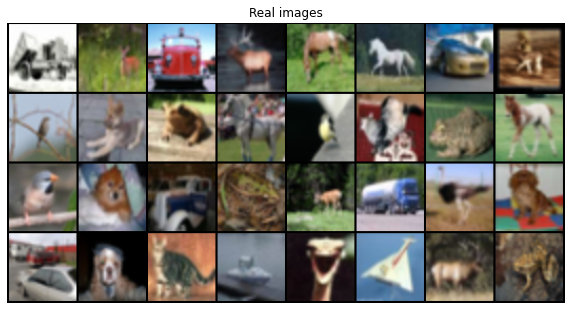

In [4]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Real images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator,self).__init__()
        
        #input 100*1*1
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(100,512,4,1,0,bias = False),
                                   nn.ReLU(True))

        #input 512*4*4
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(512,256,4,2,1,bias = False),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(True))
        #input 256*8*8
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(256,128,4,2,1,bias = False),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(True))
        #input 128*16*16
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(128,64,4,2,1,bias = False),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(True))
        #input 64*32*32
        self.layer5 = nn.Sequential(nn.ConvTranspose2d(64,3,4,2,1,bias = False),
                                   nn.Tanh())
        #output 3*64*64
      
        self.embedding = nn.Embedding(10,100)
        
        
    def forward(self,noise,label):
        
        label_embedding = self.embedding(label)
        x = torch.mul(noise,label_embedding)
        x = x.view(-1,100,1,1)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x
        

In [6]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator,self).__init__()        
        
        #input 3*64*64
        self.layer1 = nn.Sequential(nn.Conv2d(3,64,4,2,1,bias = False),
                                    nn.BatchNorm2d(64),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))
        
        #input 64*32*32
        self.layer2 = nn.Sequential(nn.Conv2d(64,128,4,2,1,bias = False),
                                    nn.BatchNorm2d(128),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))
        #input 128*16*16
        self.layer3 = nn.Sequential(nn.Conv2d(128,256,4,2,1,bias = False),
                                    nn.BatchNorm2d(256),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))
        #input 256*8*8
        self.layer4 = nn.Sequential(nn.Conv2d(256,512,4,2,1,bias = False),
                                    nn.BatchNorm2d(512),
                                   nn.LeakyReLU(0.2,True))
        #input 512*4*4
        self.validity_layer = nn.Sequential(nn.Conv2d(512,1,4,1,0,bias = False),
                                   nn.Sigmoid())
        
        self.label_layer = nn.Sequential(nn.Conv2d(512,11,4,1,0,bias = False),
                                   nn.LogSoftmax(dim = 1))
        
    def forward(self,x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        validity = self.validity_layer(x)
        plabel = self.label_layer(x)
        
        validity = validity.view(-1)
        plabel = plabel.view(-1,11)
        
        return validity,plabel

In [7]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [10]:
gen = Generator().to(device)
disc = Discriminator().to(device)
initialize_weights(gen)
initialize_weights(disc)

In [11]:
paramsG = list(gen.parameters())

paramsD = list(disc.parameters())        
        
optimG = optim.Adam(gen.parameters(), 0.0002, betas = (0.5,0.999))
optimD = optim.Adam(disc.parameters(), 0.0002, betas = (0.5,0.999))

validity_loss = nn.BCELoss()

real_labels = 0.7 + 0.5 * torch.rand(10, device = device)
fake_labels = 0.3 * torch.rand(10, device = device)

In [25]:
def showImage(images):
    images = images.cpu().numpy()
    images = images/2 + 0.5
    plt.imshow(np.transpose(images,axes = (1,2,0)))
    plt.axis('off')
    #if epoch!=-99:
        #plt.savefig("s" + str(epoch) + "r" + str(idx) + ".png")

In [ ]:
from torchvision.utils import make_grid
num_epochs=20
for epoch in range(1,num_epochs+1):
    
    for idx, (images,labels) in enumerate(dataloader,0):
        
        batch_size = images.size(0)
        labels= labels.to(device)
        images = images.to(device)
        
        real_label = real_labels[idx % 10]
        fake_label = fake_labels[idx % 10]
        
        fake_class_labels = 10*torch.ones((batch_size,),dtype = torch.long,device = device)
        
        if idx % 25 == 0:
            real_label, fake_label = fake_label, real_label
        
        optimD.zero_grad()       
        
        # real
        validity_label = torch.full((batch_size,),real_label , device = device)
   
        pvalidity, plabels = disc(images)       
        
        errD_real_val = validity_loss(pvalidity, validity_label)            
        errD_real_label = F.nll_loss(plabels,labels)
        
        errD_real = errD_real_val + errD_real_label
        errD_real.backward()
        
        D_x = pvalidity.mean().item()        
        
        #fake 
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        fakes = gen(noise,sample_labels)
        
        validity_label.fill_(fake_label)
        
        pvalidity, plabels = disc(fakes.detach())       
        
        errD_fake_val = validity_loss(pvalidity, validity_label)
        errD_fake_label = F.nll_loss(plabels, fake_class_labels)
        
        errD_fake = errD_fake_val + errD_fake_label
        errD_fake.backward()
        
        D_G_z1 = pvalidity.mean().item()
        
        #finally update the params!
        errD = errD_real + errD_fake
        
        optimD.step()
        
        optimG.zero_grad()
        
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        validity_label.fill_(1)
        
        fakes = gen(noise,sample_labels)
        pvalidity,plabels = disc(fakes)
        
        errG_val = validity_loss(pvalidity, validity_label)        
        errG_label = F.nll_loss(plabels, sample_labels)
        
        errG = errG_val + errG_label
        errG.backward()
        
        D_G_z2 = pvalidity.mean().item()
        
        optimG.step()
        
        if idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(dataloader)} "
            )
        
        
        if idx % 100 == 0:
            noise = torch.randn(10,100,device = device)  
            labels = torch.arange(0,10,dtype = torch.long,device = device)
            
            gen_images = gen(noise,labels).detach()
            
            showImage(make_grid(gen_images))

Epoch [1/20] Batch 0/1563 
Epoch [1/20] Batch 100/1563 
Epoch [1/20] Batch 200/1563 
Epoch [1/20] Batch 300/1563 
Epoch [1/20] Batch 400/1563 
Epoch [1/20] Batch 500/1563 
Epoch [1/20] Batch 600/1563 
Epoch [1/20] Batch 700/1563 
Epoch [1/20] Batch 800/1563 
Epoch [1/20] Batch 900/1563 
Epoch [1/20] Batch 1000/1563 
Epoch [1/20] Batch 1100/1563 
Epoch [1/20] Batch 1200/1563 
Epoch [1/20] Batch 1300/1563 
Epoch [1/20] Batch 1400/1563 
Epoch [1/20] Batch 1500/1563 
Epoch [2/20] Batch 0/1563 
Epoch [2/20] Batch 100/1563 
Epoch [2/20] Batch 200/1563 
Epoch [2/20] Batch 300/1563 
Epoch [2/20] Batch 400/1563 
Epoch [2/20] Batch 500/1563 
Epoch [2/20] Batch 600/1563 
Epoch [2/20] Batch 700/1563 
Epoch [2/20] Batch 800/1563 
Epoch [2/20] Batch 900/1563 
Epoch [2/20] Batch 1000/1563 
Epoch [2/20] Batch 1100/1563 
Epoch [2/20] Batch 1200/1563 
Epoch [2/20] Batch 1300/1563 
Epoch [2/20] Batch 1400/1563 
Epoch [2/20] Batch 1500/1563 
Epoch [3/20] Batch 0/1563 
Epoch [3/20] Batch 100/1563 
Epoch [3